In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.manifold import TSNE
import re

c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from main import get_last_data_path
data_dir = "data"
data_path = get_last_data_path(data_dir)

with open(data_path, "rb") as f:
    data = pickle.load(f)

c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
from consts import GEMMA_2
gemma_2_data = data[GEMMA_2]

print(gemma_2_data.keys())

dict_keys(['1161', '1200', '137', '3949', '4086', '4287', '5548', '6832', '695', '709', '7988', '8015', '1201', '1337', '14', '1555', '1752', '1818', '1838', '205', '2445', '2590', '269', '294', '3306', '384', '541', '881', '9154', '99'])


In [4]:
# NOT USED!
def train_and_save_plot(steering_vector_name, all_vectors, mlp_vs_attn):
    tsne = TSNE(n_components=2, perplexity=3, random_state=42, metric='cosine')
    X_tsne = tsne.fit_transform(all_vectors)

    reducer = umap.UMAP(n_neighbors=3, min_dist=0.1, n_components=2, random_state=42, metric='cosine')
    X_umap = reducer.fit_transform(all_vectors)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    class_names = ['vector', 'mlp', 'attn', 'resid']

    scatter1 = ax1.scatter(X_tsne[:, 0], X_tsne[:, 1], c=mlp_vs_attn, cmap='viridis', alpha=0.8)
    ax1.set_title('t-SNE Visualization', fontsize=16)
    ax1.set_xlabel('t-SNE Component 1')
    ax1.set_ylabel('t-SNE Component 2')
    ax1.grid(True, linestyle='--', alpha=0.6)
    handles, _ = scatter1.legend_elements()
    legend1 = ax1.legend(handles, class_names, title='Components')
    ax1.add_artist(legend1)

    scatter2 = ax2.scatter(X_umap[:, 0], X_umap[:, 1], c=mlp_vs_attn, cmap='viridis', alpha=0.8)
    ax2.set_title('UMAP Visualization', fontsize=16)
    ax2.set_xlabel('UMAP Component 1')
    ax2.set_ylabel('UMAP Component 2')
    ax2.grid(True, linestyle='--', alpha=0.6)
    handles, _ = scatter2.legend_elements()
    legend2 = ax2.legend(handles, class_names, title='Components')
    ax2.add_artist(legend2)

    plt.suptitle('t-SNE and UMAP - labeled by component type', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'tsne_graphs/{steering_vector_name}_tsne_umap.png')

In [5]:
class_names = ['vector', 'mlp', 'attn', 'resid']
name_mapping = {'vector': 0, 'mlp': 1, 'attn': 2}#, 'resid': 3}
all_vectors = []
mlp_vs_attn = []

for steering_vector, per_vector_data in gemma_2_data.items():
    current_vectors = []
    current_mlp_vs_attn = []

    vec = per_vector_data['meta']['direction']
    current_vectors.append(vec.float())
    current_mlp_vs_attn.append(name_mapping['vector'])
    data_at_position = per_vector_data['all']
    negative_outputs_train, positive_outputs_train, negative_outputs_test, positive_outputs_test = data_at_position
    negative_dots_train, negative_norms_train, negative_agg_train = negative_outputs_train
    positive_dots_train, positive_norms_train, positive_agg_train = positive_outputs_train

    for component_name in negative_agg_train.keys():
        # IF WE WANT ONLY THE LAST LAYERS:
        # re_pattern = 'blocks\.(\d+)\.*'
        # layer_num = re.search(re_pattern, component_name).group(1)
        # layer_num = int(layer_num)
        # if layer_num < 15:
        #     continue
        diff_means = positive_agg_train[component_name] - negative_agg_train[component_name]

        if 'ln2' in component_name:
            current_mlp_vs_attn.append(name_mapping['mlp'])
            current_vectors.append(diff_means.float())

        elif 'ln1' in component_name:
            current_mlp_vs_attn.append(name_mapping['attn'])
            current_vectors.append(diff_means.float())

    current_vectors = np.array(current_vectors)
    all_vectors.append(current_vectors)
    mlp_vs_attn.append(current_mlp_vs_attn)

    # train_and_save_plot(steering_vector, current_vectors, current_mlp_vs_attn)
all_vectors = np.array(all_vectors)
all_vectors = all_vectors.transpose(1,0,2)
all_vectors = all_vectors.reshape(all_vectors.shape[0], -1)

mlp_vs_attn = np.array(mlp_vs_attn)[0]
# mlp_vs_attn = np.array(mlp_vs_attn)
# mlp_vs_attn = mlp_vs_attn[0]

In [6]:
def run_tsne_umap(is_cosine=True):
    print("Running t-SNE...")
    if is_cosine:
        tsne = TSNE(n_components=2, perplexity=10, random_state=42, metric='cosine')
    else:
        tsne = TSNE(n_components=2, perplexity=10, random_state=42)
    X_tsne = tsne.fit_transform(all_vectors)

    print("\nRunning UMAP...")
    if is_cosine:
        reducer = umap.UMAP(n_neighbors=3, min_dist=0.1, n_components=2, random_state=42, metric='cosine')
    else:
        reducer = umap.UMAP(n_neighbors=3, min_dist=0.1, n_components=2, random_state=42)
    X_umap = reducer.fit_transform(all_vectors)

    return X_tsne, X_umap

In [21]:
def create_graph(X_tsne, X_umap):
    plt.rcParams.update({
        "font.size": 10,
        "axes.labelsize": 10,
        "axes.titlesize": 12,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "figure.figsize": (10, 7),
    })

    # fig, (ax1, ax2) = plt.subplots(1, 2)
    fig, ax1 = plt.subplots()

    colors = ['#E41A1C',  # Red
              '#56B4E9',  # Blue
              '#006400']  # Green

    markers = ['o', 's', '^', 'D']  # Circle, square, triangle, diamond

    # --- t-SNE plot ---
    for i, cls in enumerate(np.unique(mlp_vs_attn)):
        mask = mlp_vs_attn == cls
        ax1.scatter(
            X_tsne[mask, 0], X_tsne[mask, 1],
            color=colors[i], marker=markers[i],
            alpha=0.85, label=class_names[i], edgecolor='black', linewidth=0.4
        )
    ax1.set_title('t-SNE Visualization')
    ax1.set_xlabel('t-SNE Component 1')
    ax1.set_ylabel('t-SNE Component 2')
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.legend(frameon=True)

    # # --- UMAP plot ---
    # for i, cls in enumerate(np.unique(mlp_vs_attn)):
    #     mask = mlp_vs_attn == cls
    #     ax2.scatter(
    #         X_umap[mask, 0], X_umap[mask, 1],
    #         color=colors[i], marker=markers[i],
    #         alpha=0.85, label=class_names[i], edgecolor='black', linewidth=0.4
    #     )
    # ax2.set_title('UMAP Visualization')
    # ax2.set_xlabel('UMAP Component 1')
    # ax2.set_ylabel('UMAP Component 2')
    # ax2.grid(True, linestyle='--', alpha=0.3)
    # ax2.legend(frameon=True)

    plt.suptitle('t-SNE & UMAP: Steering Vector Components', fontsize=12)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save ACL-ready vector file
    plt.savefig("tsne_acl.pdf", bbox_inches="tight")

    plt.show()

Running t-SNE...

Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


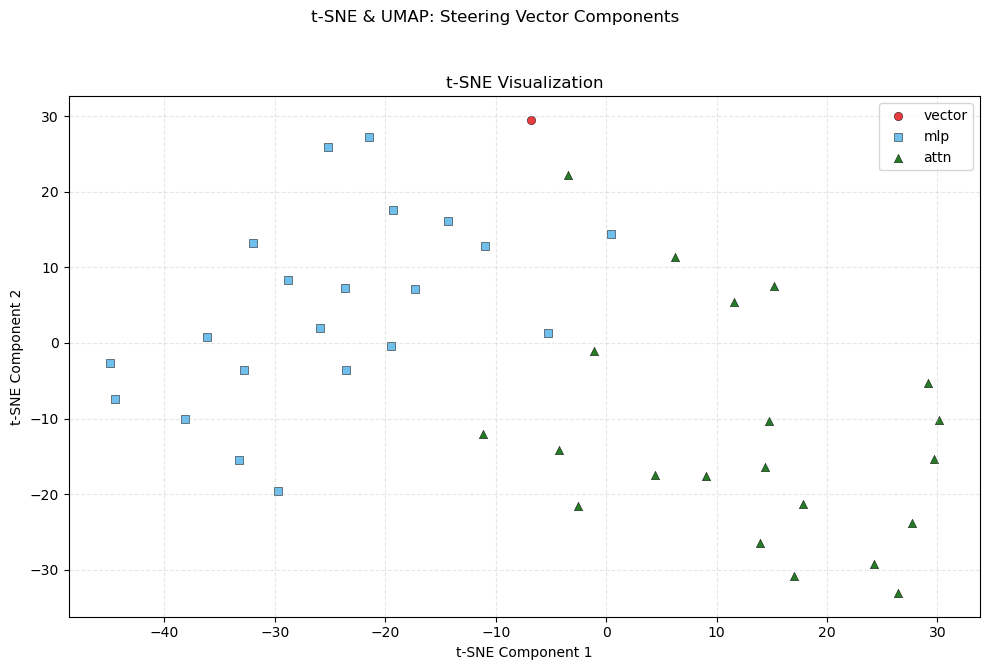

In [22]:
# RUN FOR COSINE SIMILARITY
X_tsne, X_umap = run_tsne_umap()
create_graph(X_tsne, X_umap)

Running t-SNE...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)



Running UMAP...


c:\Users\argov\miniconda3\envs\meshuggah\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


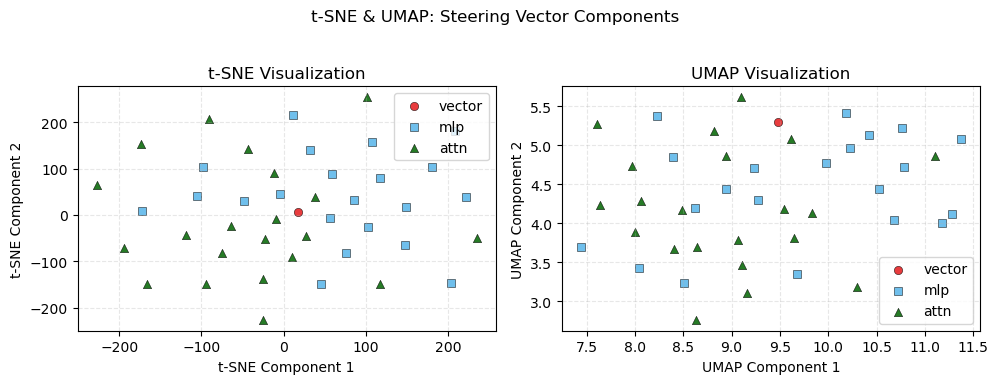

In [9]:
# RUN FOR EUCLIDEAN METHOD
X_tsne, X_umap = run_tsne_umap(is_cosine=False)
create_graph(X_tsne, X_umap)